In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

Definição das constantes - caminho do dataset e nomes das classes.

In [11]:
#ARQUIVOS
ATTRIBUTES_FILE = './dataset/attributes.csv'
LABELS_FILE = './dataset/label.csv'

CLASS_NAMES = {
    0: 'Normal',
    1: 'Charge',
    2: 'Discharge',
    3: 'Friction',
    4: 'Charge Discharge',
    5: 'Charge Friction',
    6: 'Discharge Friction',
    7: 'Charge Discharge Friction'
}

nomes_classes = list(CLASS_NAMES.values())


Os números gerados aleatoriamente pelo computador na verdade são pseudo-aleatórios. Assim, setar uma random seed constante faz com que os pesos iniciais, que são gerados aleatoriamente primeiro, sejam sempre iniciados com o mesmo valor aleatório. Para isso, travamos a aleatoriedade do numPy e do TensorFlow com .seed e set_seed. Isso trava os resultados da rede neural em sempre uma mesma acurácia.

42 é só um número atoa, ele na verdade vem da resposta para a Questão Fundamental da Vida, do Universo e Tudo Mais - O Guia do Mochileiro das Galáxias.

In [12]:
# Configuração para os dados aleatorios se repetirem
np.random.seed(24)
tf.random.set_seed(24)

### carrega_dados

**X.shape[0]**: número de linhas do array numPy com todos os dados de entrada. nesse caso, seria a quantidade de amostras disponíveis.

**X.shape[1]**: número de colunas do array numPy com todos os dados de entrada. nesse caso, seria a quantidade de colunas do csv de amostras. ou seja, quantas variações de tempo uma única amostra possui. 

**X**: 
| Amostra | feature_1 | feature_2 | ... | feature_201  |
|:---:|:---:|:---:|:---:|:---:|
| amostra 1 | valor_pressão_f1 | valor_pressão_f2 | ... | valor_pressão_f201 |
| amostra 2 | valor_pressão_f1 | valor_pressão_f2 | ... | valor_pressão_f201 |
| amostra 3 | valor_pressão_f1 | valor_pressão_f2 | ... | valor_pressão_f201 |
|  ...      |       ...        |         ...      | ... |           ...      |

**tf.keras.utils.to_categorical(y, num_classes=num_classes)**: converte rótulos de classes inteiros para formato one-hot encoded. é armazenado em uma array numPy. seu tamanho é linhas_amostras x nro_classes. 

**y_categorical**:
| Amostra | Neurônio 1 (Normal) | Neurônio 2 (Charge) | ... | Neurônio 8 (All Faults) |
|:---:|:---:|:---:|:---:|:---:|
| Linha 1 | 1 | 0 | ... | 0 |
| Linha 2 | 0 | 0 | ... | 1 |
| Linha 3 | 0 | 0 | ... | 0 |
|  ...    | 0 | 0 | ... | 0 |

In [13]:
def carrega_dados(attr_caminho, lbl_caminho):

    print(f"Lendo atributos: {attr_caminho}")
    print(f"Lendo labels: {lbl_caminho}")
    
    X_df = pd.read_csv(attr_caminho)
    y_df = pd.read_csv(lbl_caminho)

    # converte para vetor
    X = X_df.values
    y = y_df.values.flatten() 

    num_classes = len(np.unique(y))
    num_features = X.shape[1]
    
    print(f"Dataset carregado com sucesso:")
    print(f" - Amostras: {X.shape[0]}")
    print(f" - Features (Timestamps): {num_features}")
    print(f" - Classes únicas encontradas: {num_classes} {np.unique(y)}")

    # One-hot para redes neurais
    y_categorical = tf.keras.utils.to_categorical(y, num_classes=num_classes)
    
    return X, y_categorical, y, num_features, num_classes


### constroi_mlp

Define as arquiteturas das MLP usadas no artigo. A função recebe o nome da configuração, a forma de entrada (timestamps do dataset) e número de classes de saída. 

**models.Sequential()**: cria um objeto do tipo modelo sequencial -> camadas da rede serão empilhadas uma após a outra em ordem. 

**model.add(layers.InputLayer(shape=shape))**: define camada de entrada com o formato de entrada dos dados. O argumento shape informa a rede o número de features que ela receberá.

**estrutura do if**: o if definirá a camada oculta com base no nome da configuração. Se for X neurônios, model.add(layers.Dense(X, activation='relu')) adiciona uma camada densa com X neurônios e a função de ativação ReLU. A parte de 16-8N é uma topologia multi-camada, ou seja, há duas camadas ocultas: uma densa com 16 neurônios e outra densa com 8 neurônios, ambas com função de ativação ReLU. Por fim, a camada de saída é comum a todas as redes com o número de neurônios exatamente igual ao número de classes (8). A função de ativação dessa camada é a Softmax, que transforma os scores internos em probabilidades para cada classe.

Por fim, a função *constroi_mlp()* retorna o objeto model (ou seja, retorna um modelo de aprendizado) completo e pronto para treino.

In [14]:
# MODELOS (Tópico 3.4)

def constroi_mlp(config_name, shape, num_classes):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=shape))
    
    if config_name == '4N':
        model.add(layers.Dense(4, activation='relu'))
    elif config_name == '8N':
        model.add(layers.Dense(8, activation='relu'))
    elif config_name == '16N':
        model.add(layers.Dense(16, activation='relu'))
    elif config_name == '32N':
        model.add(layers.Dense(32, activation='relu'))
    elif config_name == '16-8N':
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dense(8, activation='relu'))
        
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model


### constroi_cnn

A função define as arquiteturas das CNN usadas no artigo. Recebe o nome da configuração (Mx), o formato da entrada (no nosso caso, 201 timestamps de pressão do dataset) e o número de classes (8 no nosso caso).

**models.Sequential()**: cria uma pilha linear de camadas em que os dados fluem sequencialmente de uma camada para outra.

**model.add(layers.InputLayer(shape=shape))**: a rede receberá um vetor com a forma informada na função, ou seja, receberá um vetor de 201 pontos de pressão regulada conforme nosso dataset.

**bloco if**: primeiramente seleciona a configuração base Mx. A base da M1 até a M4 é a seguinte, em que **A**, **B** e **C** são parâmetros fornecidos pelo artigo:
```python
if config == Mx, em que x = número de 1 a 4:
    model.add(layers.Conv1D(filters=**A**, kernel_size=**B**, padding='same')) 
    # Adiciona camada de convolução 1D. Aplica **A** filtro(s) deslizante(s) com o tamanho de janela de **B** pontos temporais. Isso extrai características locais da curva de presão. 
    model.add(layers.AveragePooling1D(pool_size=**C**))
    # Adiciona a camada de pooling reduzindo a dimensão dos dados tirando média a cada **C** pontos.
    model.add(layers.Flatten())
    # Adiciona camada de achatamento transformando a matriz resultante das convoluções em um vetor longo e único para entrar na camada densa
    model.add(layers.Dense(16, activation='relu'))
    # Por fim, adiciona camada densa intermediária antes da fully-connected com processamento de 16 neurônios e ReLU de ativação, sendo um padrão em todas as CNNs testadas no artigo.
    # A camada M5 possui um segundo bloco de camada de convolução 1D e pooling, ou seja, a rede é mais profunda. 
model.add(layers.Dense(num_classes, activation='softmax')) # Todas as camadas Mx, da 1 até a 5, recebem a última camada de saída com o número de neurônios = número de classes com ativação Softmax.
```

**Diferenças das configurações M1 até M5**:
- M1: configuração base das CNNs testadas, com 1 filtro deslizante, tamanho de janela de 8 pontos temporais e redução de dimensão de dados a cada 4 pontos.
- M2: os autores testaram se aumentar o número de filtros deslizantes de 1 para 2 melhora a detecção de características, com o resto igual a M1.
- M3: o artigo testa se uma janela de observação maior de 16 pontos temporais captura melhores padrões, com o resto igual a M1.
- M4: aumenta o número da redução da dimensão de dados de 4 para 8, com o resto igual a M1.
- M5: adiciona segundo bloco de convolução 1D e pooling, testando se uma rede mais profunda com duas camadas de convolução melhora o desempenho.

Por fim, a função retorna o modelo de aprendizado construído.

In [15]:
def constroi_cnn(config_name, shape, num_classes):
    model = models.Sequential()
    model.add(layers.InputLayer(shape=shape))
    
    if config_name == 'M1':
        model.add(layers.Conv1D(filters=1, kernel_size=8)) # tirei o padding = 'same' para testar se acurácia da M5 cai
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M2':
        model.add(layers.Conv1D(filters=2, kernel_size=8)) # tirei o padding = 'same' para testar se acurácia da M5 cai
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M3':
        model.add(layers.Conv1D(filters=1, kernel_size=16)) # tirei o padding = 'same' para testar se acurácia da M5 cai
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M4':
        model.add(layers.Conv1D(filters=1, kernel_size=8)) # tirei o padding = 'same' para testar
        model.add(layers.AveragePooling1D(pool_size=8))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))
        
    elif config_name == 'M5':
        model.add(layers.Conv1D(filters=1, kernel_size=8)) # tirei o padding = 'same' para testar se acurácia da M5 cai
        model.add(layers.AveragePooling1D(pool_size=4))
        model.add(layers.Conv1D(filters=1, kernel_size=8))
        model.add(layers.AveragePooling1D(pool_size=2))
        model.add(layers.Flatten())
        model.add(layers.Dense(16, activation='relu'))

    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

### Experimentação

Primeiramente há o carregamento dos dados por meio da função carrega_dados() anteriormente discutida. Há o retorno das variáveis:
- **X**: matriz com as 8000 amostras de pressão.
- **y_cat**: rótulos das categorias de classificação no formato one-hot encoded.
- **y_integers**: rótulos das categorias em formato original para usar na estratificação da validação cruzada.
- **n_features**: número de momentos diferentes da mesma pressão, no caso, 201.
- **n_classes**: quantas classes o problema de classificação possui.

**Separação do dataset**: é por meio da função train_test_split(). A função recebe o dataset inteiro (**X**), os rótulos das categorias hot encoded (**y_cat**), os rótulos das categorias inteiros (**y_integers**), o tamanho do dataset de teste pretendido, nesse caso, 10% ou seja, **test_size = 0.10**. O dataset de teste nunca encontrará o dataset de treino, essa função garante que a informação testada nunca tenha sido reconhecida pelo modelo anteriormente. O atributo **stratify** da função garante a amostragem estratificada mantendo a mesma proporção de falhas tanto no treino quanto no teste. Ele recebe y_integers como valor, ou seja, identifica-se quantas classes devem ser garantidas na mesma porcentagem. O **random_state = 0.42** garante que a divisão seja sempre a mesma. Por fim, a função devolve o dataset de treino em **X_train**, o dataset de teste em **X_test**, as classes de treino em **y_train**, as classes de teste em **y_test** tanto em hot encoded quanto em inteiros (**y_train_int** e **y_test_int**).

**Preparação de dados para a CNN**: as matrizes de dados **X_train** e **X_test** não estão no formato esperado pelas camadas convolucionais (Conv1D) da biblioteca Keras, que exigem uma entrada tridimensional (amostras, timesteps, canais). Por isso, utiliza-se a função reshape() para adicionar uma dimensão extra de tamanho 1 ao final, representando o único canal da série temporal. As novas variáveis **X_train_cnn** e **X_test_cnn** assumem o formato (amostras, 201, 1).

**Definição dos formatos de entrada**: são criadas as tuplas **mlp_shape** e **cnn_shape** para informar à primeira camada de cada rede qual o formato dos dados que entrarão. Para o MLP é um vetor plano de (201,) e para a CNN é a estrutura de (201, 1).

**Definição de Hiperparâmetros**: são estabelecidas as constantes que guiarão o processo de treinamento:
- **EPOCHS** = 50: define que o modelo passará pelo dataset completo 50 vezes durante o treino.
- **BATCH_SIZE** = 32: indica que os pesos da rede serão atualizados a cada 32 amostras processadas.
- **K_FOLDS** = 10: define que a validação cruzada dividirá os dados de treino em 10 partes distintas.

**Configuração da Validação Cruzada**: inicializa-se uma lista vazia resultados para armazenar as métricas de cada rodada. O objeto **skf** é instanciado usando a classe StratifiedKFold. Ele é configurado com **n_splits=10** (para dividir em 10 partes), **shuffle=True** (para embaralhar os dados antes da divisão e evitar viés de ordem) e **random_state=42** (para garantir a reprodutibilidade dos folds). Esse objeto não divide os dados imediatamente, mas define a lógica que será usada no loop de treinamento.

In [16]:
# EXPERIMENTOS
    
X, y_cat, y_integers, n_features, n_classes = carrega_dados(ATTRIBUTES_FILE, LABELS_FILE)

# divisao treino/teste (10% Teste)
X_train, X_test, y_train, y_test, y_train_int, y_test_int = train_test_split(
    X, y_cat, y_integers, test_size=0.10, stratify=y_integers, random_state=24
)

# CNN: (samples, timesteps, features=1)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

mlp_shape = (n_features,)
cnn_shape = (n_features, 1)

EPOCHS = 50 
BATCH_SIZE = 32
K_FOLDS = 10

resultados = []
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=24)

print(f"\nIniciando Validação Cruzada (K={K_FOLDS})...")

Lendo atributos: ./dataset/attributes.csv
Lendo labels: ./dataset/label.csv
Dataset carregado com sucesso:
 - Amostras: 8000
 - Features (Timestamps): 201
 - Classes únicas encontradas: 8 [0 1 2 3 4 5 6 7]

Iniciando Validação Cruzada (K=10)...


In [17]:
# Dicionário para guardar as médias de loss de cada configuração

historico_perdas = {'MLP': {}, 'CNN': {}}

### Rodando as arquiteturas MLP

**Avaliação das topologias MLP**: define-se a lista **configuracoes_mlp** contendo as chaves das arquiteturas propostas no artigo, variando de '4N' até '16-8N'. O loop principal percorre cada configuração **cfg**. Assim como na etapa anterior, executa-se **tf.keras.backend.clear_session()** antes dos folds para garantir que a memória esteja limpa e evitar interferências entre treinamentos. Inicializam-se as listas **loss_train_folds** e **loss_val_folds** para acumular as curvas de perda de cada iteração.

**Loop de Validação Cruzada**: utiliza-se o método **skf.split()** aplicado aos dados de treino (**X_train**) e seus rótulos inteiros (**y_train_int**). Esse método gera, para cada uma das 10 iterações (folds), os índices específicos de treino (**train_idx**) e validação (**val_idx**). Com base nesses índices, os dados são fatiados criando os subconjuntos de treino do fold (**X_fold_train**, **y_fold_train**) e os de validação do fold (**X_fold_val**, **y_fold_val**).

**Construção e Treinamento com Monitoramento**: para cada fold, uma nova instância limpa do modelo é instanciada via **constroi_mlp()**, recebendo a configuração atual e o formato de entrada **mlp_shape**. O modelo é compilado definindo o otimizador como **adam** e a função de perda como **categorical_crossentropy**. O treinamento é executado via **model.fit()**, agora incluindo o parâmetro **validation_data=(X_fold_val, y_fold_val)** para registrar a perda de validação a cada época. Todo o processo de treinamento é salvo na variável **historico**.

**Armazenamento das Curvas de Perda**: extraem-se os valores de perda (*loss* e *val_loss*) do objeto **historico** e eles são anexados às listas de controle. Após a conclusão dos 10 folds, calcula-se a média dessas curvas (**np.mean(..., axis=0)**) e armazena-se o resultado suavizado no dicionário **historico_perdas['MLP']**, permitindo a visualização posterior da convergência.

**Coleta de Métricas e Agregação**: imediatamente após o treino, o modelo é submetido aos dados de validação através de **model.evaluate()**, e a acurácia obtida é armazenada na lista temporária **rel_acuracia**. Ao término dos 10 folds para uma configuração, calculam-se a média (**mean_acc**) e o desvio padrão (**std_acc**) das acurácias observadas. Esses valores consolidados são adicionados à lista **resultados**, registrando o tipo de modelo ('MLP'), a configuração testada e suas métricas de validação.

In [18]:
# MLP
configuracoes_mlp = ['4N', '8N', '16N', '32N', '16-8N']
for cfg in configuracoes_mlp:
    print(f"Avaliando MLP: {cfg}")
    tf.keras.backend.clear_session()
    rel_acuracia = []

    loss_train_folds = [] # acumula curvas dos folds de treino
    loss_val_folds = [] # acumula curvas dos folds de validation

    for train_idx, val_idx in skf.split(X_train, y_train_int):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model = constroi_mlp(cfg, mlp_shape, n_classes)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(
            X_fold_train, y_fold_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(X_fold_val, y_fold_val)
        ) # acrescentado atributo validation_data para guardar cada dado de validação gerado no fit

        loss_train_folds.append(history.history['loss'])
        loss_val_folds.append(history.history['val_loss'])

        historico_perdas['MLP'][cfg] = {
            'train': np.mean(loss_train_folds, axis=0),
            'val': np.mean(loss_val_folds, axis=0)
        } # média das curvas entre os 10 folds para suavizar a curva

        _, acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        rel_acuracia.append(acc)
        
    mean_acc = np.mean(rel_acuracia)
    std_acc = np.std(rel_acuracia)
    resultados.append({'Model': 'MLP', 'Config': cfg, 'Val_Acc_Mean': mean_acc, 'Val_Acc_Std': std_acc})
    print(f"  -> Acurácia Média: {mean_acc:.4f}")
    print(f"  -> Desvio Médio: {std_acc:.4f}")


Avaliando MLP: 4N
  -> Acurácia Média: 0.9914
  -> Desvio Médio: 0.0062
Avaliando MLP: 8N
  -> Acurácia Média: 0.9951
  -> Desvio Médio: 0.0031
Avaliando MLP: 16N
  -> Acurácia Média: 0.9963
  -> Desvio Médio: 0.0037
Avaliando MLP: 32N
  -> Acurácia Média: 0.9976
  -> Desvio Médio: 0.0022
Avaliando MLP: 16-8N
  -> Acurácia Média: 0.9962
  -> Desvio Médio: 0.0028


### Rodando as arquiteturas CNN

**Avaliação das topologias CNN**: estabelece-se a lista **configuracoes_cnn** com as variações de arquitetura descritas no estudo, indo de 'M1' a 'M5'. O loop principal percorre cada configuração **cfg**. Antes de iniciar os folds, executa-se **tf.keras.backend.clear_session()** para liberar a memória da GPU/CPU, evitando vazamento de estados entre modelos. Inicializam-se também as listas **loss_train_folds** e **loss_val_folds** para acumular o histórico de aprendizado.

**Loop de Validação Cruzada**: repete-se a lógica de divisão utilizada anteriormente com o método **skf.split()**, garantindo que os mesmos índices de folds sejam usados, o que permite uma comparação justa entre MLP e CNN. A diferença crucial ocorre no fatiamento dos dados: as variáveis **X_fold_train** e **X_fold_val** são extraídas da matriz **X_train_cnn** (previamente redimensionada para 3 dimensões), enquanto os rótulos **y_fold_train** e **y_fold_val** continuam vindo do vetor original **y_train**.

**Construção e Treinamento com Monitoramento**: a cada iteração do fold, o modelo é instanciado pela função **constroi_cnn()** e compilado com otimizador **adam** e perda **categorical_crossentropy**. O ajuste dos pesos via **model.fit()** recebe um argumento adicional crucial: **validation_data=(X_fold_val, y_fold_val)**. Isso força o modelo a calcular a perda nos dados de validação ao final de cada época, sem treinar neles. O objeto de retorno é capturado na variável **historico**.

**Armazenamento das Curvas de Perda**: extraem-se os vetores de perda de treino e validação do objeto **historico**, acumulando-os nas listas temporárias. Ao fim de cada fold, armazena-se no dicionário global **historico_perdas['CNN']** a média aritmética dessas curvas (**np.mean(..., axis=0)**). Esse procedimento suaviza as oscilações naturais de cada fold individual, gerando uma curva representativa do comportamento daquela arquitetura.

**Coleta de Métricas e Agregação**: o desempenho final do modelo no fold é medido através de **model.evaluate()**, salvando a acurácia na lista **rel_acuracia**. Ao final do ciclo de 10 folds, computam-se a média (**mean_acc**) e o desvio padrão (**std_acc**). Os dados são estruturados e anexados à lista geral **resultados**, permitindo a comparação direta de performance com os modelos MLP.

In [19]:
# CNN
configuracoes_cnn = ['M1', 'M2', 'M3', 'M4', 'M5']

for cfg in configuracoes_cnn:
    print(f"Avaliando CNN: {cfg}")

    tf.keras.backend.clear_session()

    loss_train_folds = [] # acumula curvas dos folds de treino
    loss_val_folds = [] # acumula curvas dos folds de validation

    rel_acuracia = []

    for train_idx, val_idx in skf.split(X_train, y_train_int):
        X_fold_train, X_fold_val = X_train_cnn[train_idx], X_train_cnn[val_idx]
        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

        model = constroi_cnn(cfg, cnn_shape, n_classes)

        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        history = model.fit(
            X_fold_train, y_fold_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=0,
            validation_data=(X_fold_val, y_fold_val)
        ) # acrescentado atributo validation_data para guardar cada dado de validação gerado no fit

        loss_train_folds.append(history.history['loss'])
        loss_val_folds.append(history.history['val_loss'])

        historico_perdas['CNN'][cfg] = {
            'train': np.mean(loss_train_folds, axis=0),
            'val': np.mean(loss_val_folds, axis=0)
        } # média das curvas entre os 10 folds para suavizar a curva

        _, acc = model.evaluate(X_fold_val, y_fold_val, verbose=0)
        rel_acuracia.append(acc)
        
    mean_acc = np.mean(rel_acuracia)
    std_acc = np.std(rel_acuracia)
    resultados.append({'Model': 'CNN', 'Config': cfg, 'Val_Acc_Mean': mean_acc, 'Val_Acc_Std': std_acc})
    print(f"  -> Acurácia Média: {mean_acc:.4f}")
    print(f"  -> Desvio Médio: {std_acc:.4f}")


Avaliando CNN: M1
  -> Acurácia Média: 0.9961
  -> Desvio Médio: 0.0023
Avaliando CNN: M2
  -> Acurácia Média: 0.9964
  -> Desvio Médio: 0.0025
Avaliando CNN: M3
  -> Acurácia Média: 0.9953
  -> Desvio Médio: 0.0039
Avaliando CNN: M4
  -> Acurácia Média: 0.9931
  -> Desvio Médio: 0.0035
Avaliando CNN: M5
  -> Acurácia Média: 0.9933
  -> Desvio Médio: 0.0058


### Rodando a KNN

**Avaliação do KNN**: define-se a lista **k_values** contendo os hiperparâmetros de vizinhos a serem testados, variando de 1 a 20, conforme estipulado no artigo para comparação com as redes neurais. O loop itera sobre cada valor **k** para realizar a validação cruzada.

**Loop de Validação Cruzada**: utiliza-se novamente o objeto **skf.split()** para garantir que os folds sejam idênticos aos experimentos anteriores. Uma distinção importante ocorre aqui: enquanto as redes neurais utilizavam rótulos one-hot encoded, o KNN utiliza os vetores de rótulos inteiros. Portanto, as variáveis de alvo **y_fold_train_labels** e **y_fold_val_labels** são extraídas diretamente de **y_train_int** (formato original 0-7) com base nos índices do fold atual.

**Construção e Treinamento**: para cada fold, instancia-se o classificador **KNeighborsClassifier** configurado com o número de vizinhos **n_neighbors=k** da iteração atual. O método **knn.fit()** é chamado para ajustar o modelo aos dados de treino do fold. Diferente das redes neurais que requerem múltiplas épocas, o KNN é um algoritmo de aprendizado preguiçoso (*lazy learning*), onde o "treinamento" consiste basicamente no armazenamento dos dados para cálculos de distância posteriores.

**Coleta de Métricas e Agregação**: a avaliação é feita através de **knn.score()**, que retorna diretamente a acurácia do modelo nos dados de validação. Esse valor é acumulado na lista **rel_acuraacia**. Ao final dos 10 folds, calculam-se a média (**mean_acc**) e o desvio padrão (**std_acc**). O dicionário de resultados é atualizado com o identificador 'KNN', o valor de K testado e as métricas estatísticas consolidadas.

In [20]:
# KNN
k_values = [1, 2, 5, 10, 20]
print("\nAvaliando KNN...")
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    tf.keras.backend.clear_session()
    rel_acuracia = []
    for train_idx, val_idx in skf.split(X_train, y_train_int):
        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
        y_fold_train_labels = y_train_int[train_idx]
        y_fold_val_labels = y_train_int[val_idx]
        knn.fit(X_fold_train, y_fold_train_labels)
        acc = knn.score(X_fold_val, y_fold_val_labels)
        rel_acuracia.append(acc)
    
    mean_acc = np.mean(rel_acuracia)
    std_acc = np.std(rel_acuracia)
    resultados.append({'Model': 'KNN', 'Config': f'K={k}', 'Val_Acc_Mean': mean_acc, 'Val_Acc_Std': std_acc})
    print(f"  -> Acurácia Média: {mean_acc:.4f}")
    print(f"  -> Desvio Médio: {std_acc:.4f}")


Avaliando KNN...
  -> Acurácia Média: 0.8825
  -> Desvio Médio: 0.0137
  -> Acurácia Média: 0.8542
  -> Desvio Médio: 0.0090
  -> Acurácia Média: 0.8899
  -> Desvio Médio: 0.0081
  -> Acurácia Média: 0.8801
  -> Desvio Médio: 0.0101
  -> Acurácia Média: 0.8636
  -> Desvio Médio: 0.0082


### Comparando arquiteturas 

**Seleção dos Melhores Modelos**: primeiramente, transforma-se a lista de resultados obtidos na validação cruzada em um DataFrame do pandas (**resultados_df**) para manipulação estatística. Utiliza-se o método **.groupby()** agrupar os resultados por tipo de modelo ('MLP', 'CNN', 'KNN') e o **.idxmax()** para encontrar o índice da configuração que obteve a maior acurácia média em cada grupo. O resultado é armazenado em **melhores_por_tipo**, que contém apenas os três "campeões" (o melhor MLP, a melhor CNN e o melhor KNN).

**Retreinamento e Teste Final**: inicia-se um loop para iterar sobre esses três modelos vencedores. É crucial notar que, nesta etapa, a validação cruzada já cumpriu seu papel de seleção. Agora, o objetivo é avaliar a performance real:
* O modelo é reconstruído do zero com a configuração vencedora.
* O treinamento (**fit**) é realizado utilizando **todo o conjunto de treino** (**X_train** e **y_train**), e não apenas parciais dos folds. Isso maximiza o aprendizado.
* A avaliação definitiva ocorre no conjunto de teste (**X_test**), que representa os 10% de dados virgens separados no início do script.

**Predição e Processamento de Saídas**:
* Para **MLP e CNN**: como são redes neurais com saída Softmax, o método **.predict()** retorna o vetor **y_pred_probs** contendo as probabilidades para cada classe. Aplica-se a função **np.argmax(axis=1)** para identificar o índice da maior probabilidade, resultando no vetor **y_pred**, que contém a classe final prevista pelo modelo. Da mesma forma, **y_true** é obtido aplicando argmax no vetor de teste (que está em one-hot encoded) para recuperar o índice da classe real (onde está o bit 1).
* Para **KNN**: o método **.predict()** já retorna diretamente as classes previstas, sem necessidade de argmax.

**Geração da Matriz de Confusão**: com os vetores de classes reais (**y_true**) e previstos (**y_pred**) em mãos, calcula-se a matriz de confusão via **confusion_matrix()**. Para visualização, utiliza-se a biblioteca Seaborn (**sns.heatmap**) para plotar um mapa de calor, onde os eixos representam a "Previsão" e a "Realidade", facilitando a identificação de onde o modelo está acertando ou confundindo as classes (ex: confundindo falhas múltiplas).

**Relatório Final**: o script exibe a **Acurácia Final** de cada tipo de modelo no conjunto de teste e, por fim, imprime um resumo completo ordenado pela acurácia média da validação, permitindo uma visão global do desempenho de todas as arquiteturas testadas.


MELHORES POR TIPO
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Matriz de Confusão para CNN:
-> Acurácia Final (CNN): 0.9937

Matriz de Confusão para KNN:
-> Acurácia Final (KNN): 0.8950

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Matriz de Confusão para MLP:
-> Acurácia Final (MLP): 0.9962



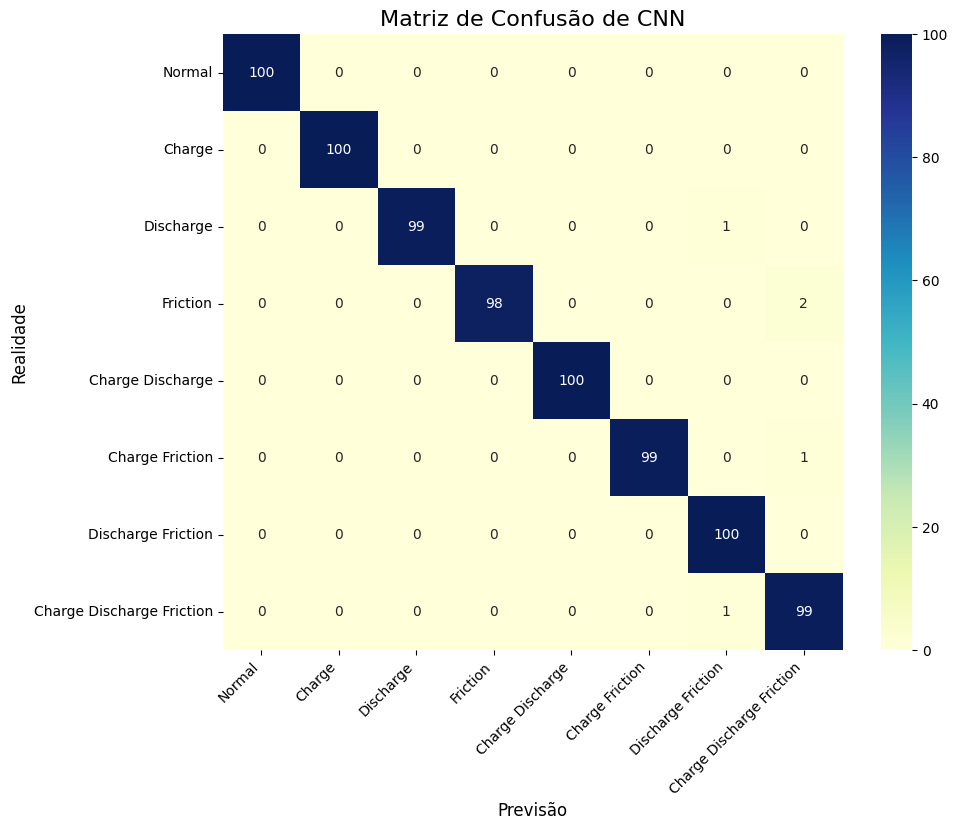

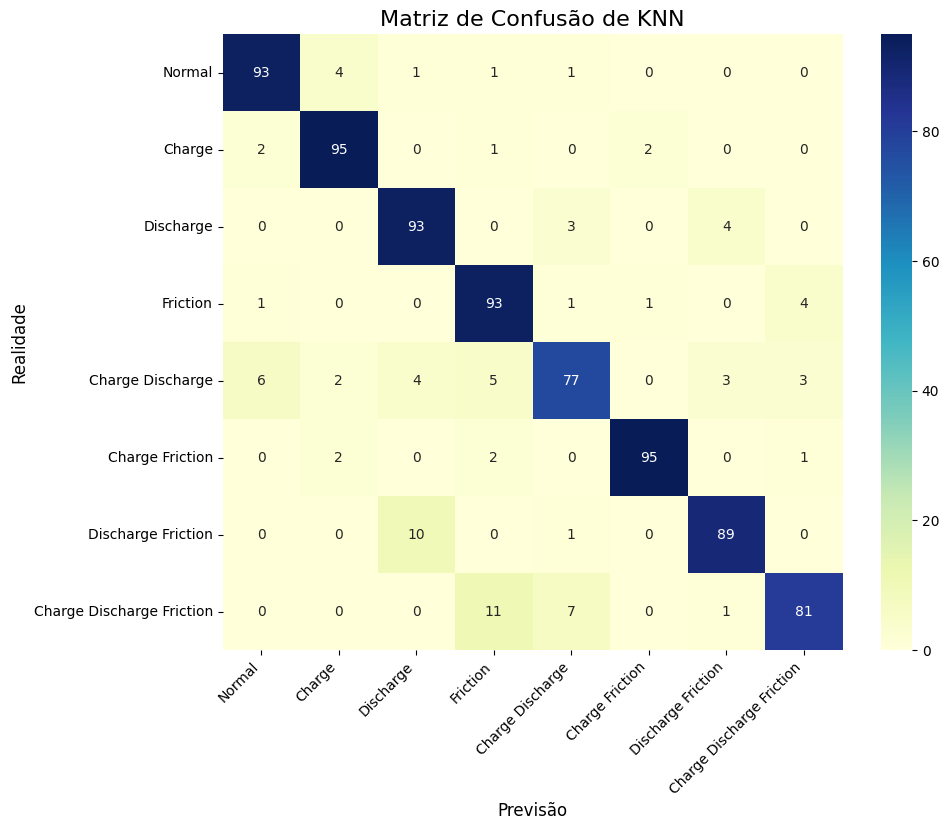

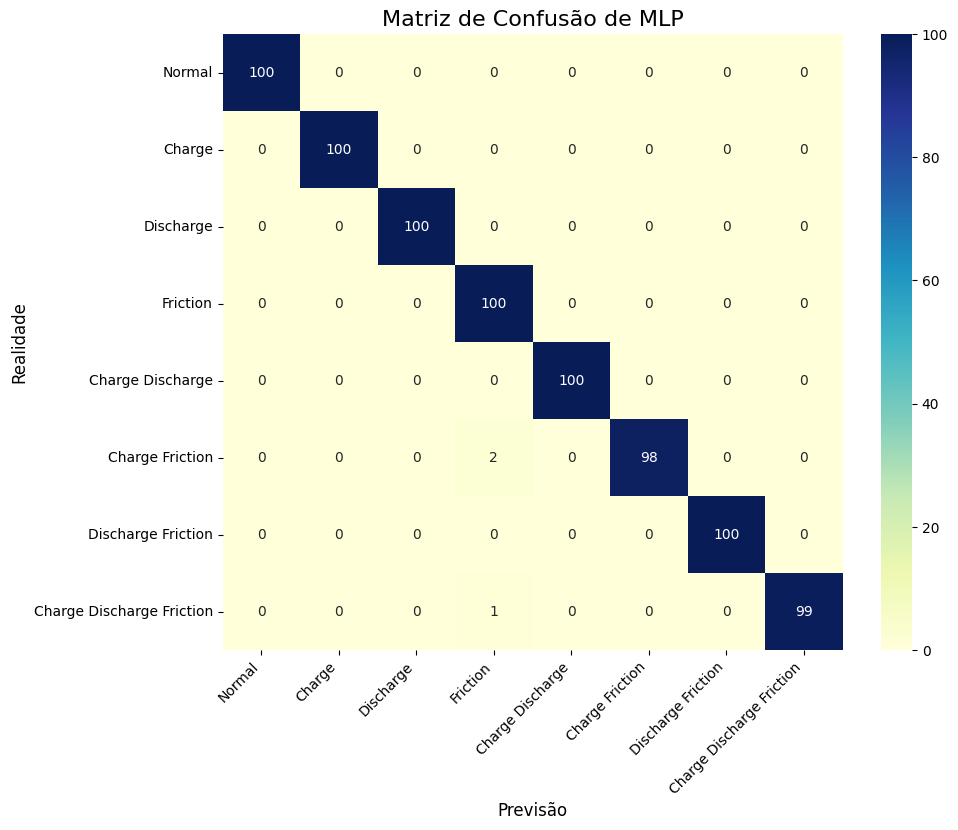

In [40]:
# Resultado Final
resultados_df = pd.DataFrame(resultados)

# índice de melhor modelo para cada tipo de modelo
idx_melhores = resultados_df.groupby('Model')['Val_Acc_Mean'].idxmax()
melhores_por_tipo = resultados_df.loc[idx_melhores]

print("\n" + "="*40)
print("MELHORES POR TIPO")
print("="*40)

matrizes_confusao = {}

# treinando cada melhor modelo de novo e depois testando com o conjunto de teste
for _, row in melhores_por_tipo.iterrows():
    tipo_modelo = row['Model']
    config = row['Config']
    final_acc = 0

    if tipo_modelo == 'MLP':
        mlp_final = constroi_mlp(config, mlp_shape, n_classes)
        mlp_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        mlp_final.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        loss, final_acc = mlp_final.evaluate(X_test, y_test, verbose=0)
        y_pred_probs = mlp_final.predict(X_test) # saída da CNN, é o vetor de probabilidades gerado pela função softmax
        y_pred = np.argmax(y_pred_probs, axis=1) # pega a maior probabilidade da saída e me retorna a posição dela, ou seja, qual classe o modelo preveu
        y_true = np.argmax(y_test, axis=1) # é a classe verdadeira do dado, retorno a posição de onde está o bit 1, pois está em one hot encoded 
        
    elif tipo_modelo == 'CNN':
        modelo_final = constroi_cnn(config, cnn_shape, n_classes)
        modelo_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        modelo_final.fit(X_train_cnn, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0)
        loss, final_acc = modelo_final.evaluate(X_test_cnn, y_test, verbose=0)
        y_pred_probs = modelo_final.predict(X_test_cnn)
        y_pred = np.argmax(y_pred_probs, axis=1) 
        y_true = np.argmax(y_test, axis=1)
        
    elif tipo_modelo == 'KNN':
        k = int(config.split('=')[1])
        modelo_final = KNeighborsClassifier(n_neighbors=k)
        modelo_final.fit(X_train, y_train_int)
        final_acc = modelo_final.score(X_test, y_test_int)
        y_pred = modelo_final.predict(X_test)
        y_true = y_test_int

    cm = confusion_matrix(y_true, y_pred)
    matrizes_confusao[tipo_modelo] = cm
    plt.figure(figsize=(10, 8))
    print(f"Matriz de Confusão para {tipo_modelo}:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=nomes_classes, yticklabels=nomes_classes)
    plt.xlabel('Previsão', fontsize=12)
    plt.ylabel('Realidade', fontsize=12)
    plt.title(f'Matriz de Confusão de {tipo_modelo}', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    nome_saida = "./images/matriz_confusao_" + tipo_modelo + ".png"
    plt.savefig(nome_saida, dpi=600)
    #plt.show()

    print(f"-> Acurácia Final ({tipo_modelo}): {final_acc:.4f}\n")


Matriz de Confusão Combinada


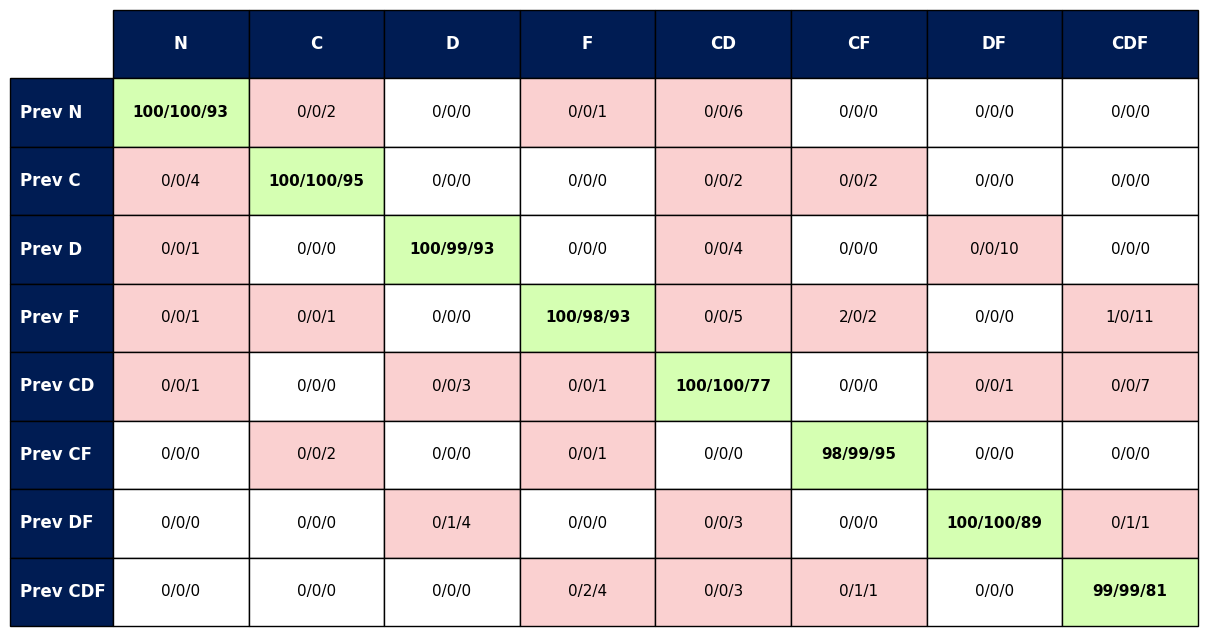

In [48]:
# Geração da matriz de confusão combinada 
print("\n" + "="*40)
print("Matriz de Confusão Combinada")
print("="*40)
if all(k in matrizes_confusao for k in ['MLP', 'CNN', 'KNN']):
    cm_mlp = matrizes_confusao['MLP'].T
    cm_cnn = matrizes_confusao['CNN'].T
    cm_knn = matrizes_confusao['KNN'].T

    matriz_combinada = np.empty((8, 8), dtype=object)

    for i in range(8):
        for j in range(8):
            matriz_combinada[i, j] = f"{cm_mlp[i,j]}/{cm_cnn[i,j]}/{cm_knn[i,j]}"

    labels_colunas = ['N', 'C', 'D', 'F', 'CD', 'CF', 'DF', 'CDF']
    labels_linhas = [f'Prev {l}' for l in labels_colunas]

    df_combinado = pd.DataFrame(matriz_combinada, index=labels_linhas, columns=labels_colunas)
    #print(df_combinado)
else: 
    print("Falha ao gerar matriz de confusão combinada.")

fig, ax = plt.subplots(figsize=(14, 8)) 

ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df_combinado.values,
                 colLabels=df_combinado.columns,
                 rowLabels=df_combinado.index,
                 loc='center',
                 cellLoc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11) 

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    cell.set_linewidth(1)
    
    
    if row == 0:
        cell.set_facecolor("#001C53") 
        cell.set_text_props(weight='bold', color='white', size=12)
    
    elif col == -1: 
        cell.set_facecolor("#001C53") 
        cell.set_text_props(weight='bold', color='white', size=12)
    
    else:
        if row == col + 1:
            cell.set_facecolor("#d5ffb2") 
            cell.set_text_props(weight='bold', color='black')
        else:
            texto = cell.get_text().get_text() 
            if texto != "0/0/0":
                cell.set_facecolor("#fad0d0") 
            else:
                cell.set_facecolor('white') 

nome_saida_combinada = "./images/matriz_confusao_COMBINADA.png"
plt.savefig(nome_saida_combinada, dpi=600)

plt.show()


Resumo Completo da Validação Cruzada:
   Model Config  Val_Acc_Mean  Val_Acc_Std
3    MLP    32N      0.997639     0.002156
6    CNN     M2      0.996389     0.002500
2    MLP    16N      0.996250     0.003677
4    MLP  16-8N      0.996250     0.002781
5    CNN     M1      0.996111     0.002307
7    CNN     M3      0.995278     0.003938
1    MLP     8N      0.995139     0.003121
9    CNN     M5      0.993333     0.005820
8    CNN     M4      0.993056     0.003458
0    MLP     4N      0.991389     0.006236
12   KNN    K=5      0.889861     0.008147
10   KNN    K=1      0.882500     0.013654
13   KNN   K=10      0.880139     0.010093
14   KNN   K=20      0.863611     0.008236
11   KNN    K=2      0.854167     0.009001


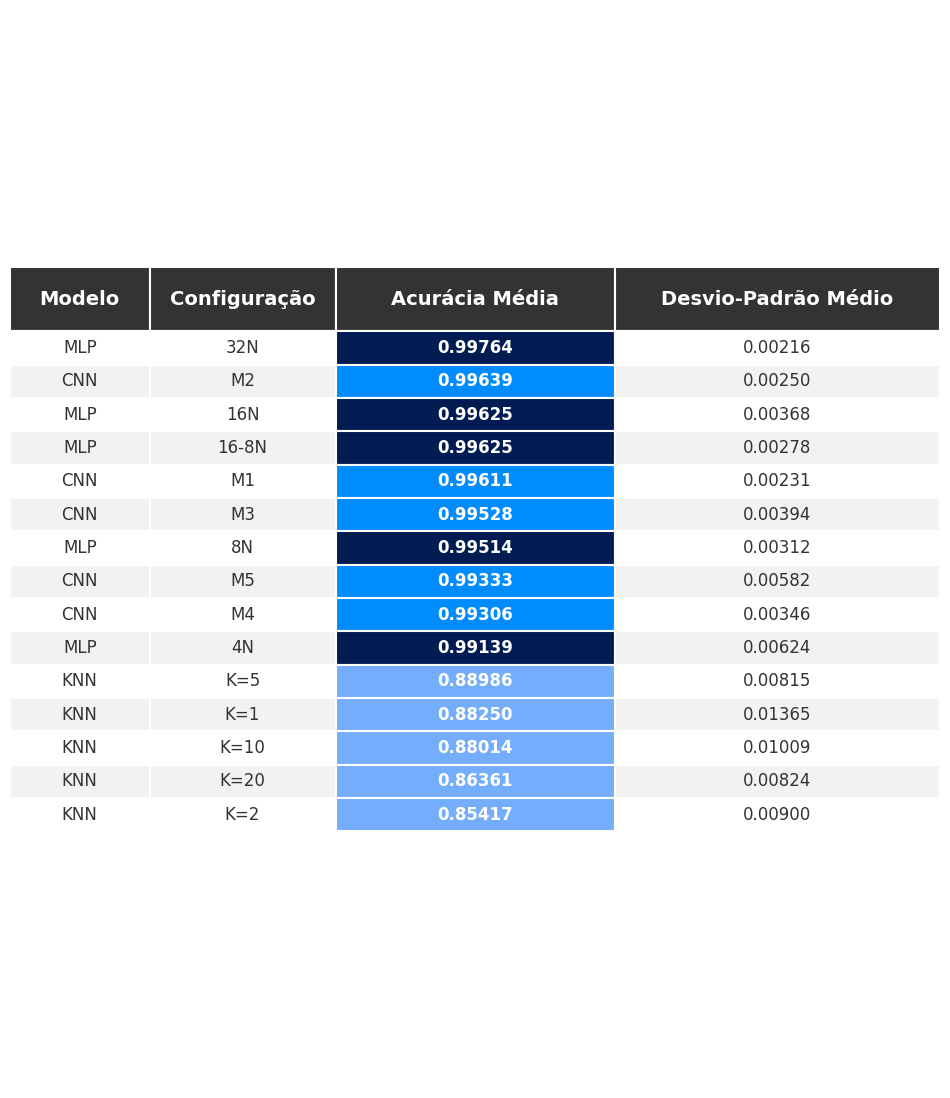

In [35]:
# Geração de tabela para resultados da validação cruzada

print("\nResumo Completo da Validação Cruzada:")
print(resultados_df[['Model', 'Config', 'Val_Acc_Mean', 'Val_Acc_Std']].sort_values(by='Val_Acc_Mean', ascending=False))

df = pd.DataFrame({
    "Modelo": resultados_df['Model'],
    "Configuracao": resultados_df['Config'],
    "Media_Acuracia": resultados_df['Val_Acc_Mean'],
    "Media_DP": resultados_df['Val_Acc_Std'],
})

df = df.sort_values(by='Media_Acuracia', ascending=False)

df['Media_Acuracia'] = df['Media_Acuracia'].map('{:.5f}'.format)
df['Media_DP'] = df['Media_DP'].map('{:.5f}'.format)

CORES = {
    "MLP": "#001C53", 
    "CNN": "#008CFF",  
    "KNN": "#74ADFC"   
}

df["Cor"] = df["Modelo"].map(CORES)

fig, ax = plt.subplots(figsize=(12, 14)) 

ax.axis('off')
ax.axis('tight')

dados_tabela = df[["Modelo", "Configuracao", "Media_Acuracia", "Media_DP"]].values
cabecalhos = ["Modelo", "Configuração", "Acurácia Média", "Desvio-Padrão Médio"]

table = ax.table(cellText=dados_tabela,
                 colLabels=cabecalhos,
                 loc='center',
                 cellLoc='center',
                 colWidths=[0.15, 0.20, 0.30, 0.35])

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2.0) 


for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('white')
    cell.set_linewidth(1.5)
    
    if row == 0:
        cell.set_text_props(weight='bold', color='white', size=14)
        cell.set_facecolor('#333333')
        cell.set_height(0.06)
    
    else:
        idx_real = row - 1
        com_id = df.iloc[idx_real]["Modelo"] 
        
        if col == 2:
            cor_fundo = CORES.get(com_id, "#cccccc")
            cell.set_facecolor(cor_fundo)
            cell.set_text_props(weight='bold', color='white')
        
        else:
            if row % 2 == 0:
                cell.set_facecolor('#f2f2f2')
            else:
                cell.set_facecolor('#ffffff')
            cell.set_text_props(color='#333333')

nome_saida = "./images/tabela_desempenhos.png"
plt.savefig(nome_saida, dpi=600, bbox_inches='tight')

plt.show()

### Visualização das Curvas de Aprendizado

**Definição da Função de Plotagem**: define-se a função **plotar_curvas_loss()** que recebe como argumentos o dicionário de históricos acumulados (**historico**) e a chave do tipo de modelo a ser visualizado (**tipo_modelo**, ex: 'MLP' ou 'CNN'). O objetivo é gerar gráficos comparativos que permitam analisar a convergência e o ajuste dos modelos ao longo das épocas.

**Configuração da Figura**: utiliza-se **plt.subplots(1, 2)** para criar uma figura contendo dois gráficos lado a lado: o primeiro (**ax1**) dedicado aos dados de treino e o segundo (**ax2**) aos dados de validação. As dimensões da figura são fixadas em 18x6 polegadas para garantir legibilidade. A variável **epochs** define o eixo X, representando o intervalo de épocas percorrido durante o treinamento.

**Plotagem das Curvas de Treino**: itera-se sobre cada configuração (**cfg**) e suas respectivas métricas armazenadas no dicionário. No eixo **ax1**, plota-se a curva de perda média de treinamento (**curvas['train']**). Adicionam-se elementos visuais essenciais: título ('Função de Perda no treino'), rótulos dos eixos, legenda para identificar cada configuração ('4N', 'M1', etc.) e grade (**grid**) para facilitar a leitura dos valores.

**Plotagem das Curvas de Validação**: repete-se a lógica de iteração para o eixo **ax2**, porém plotando a curva de perda média de validação (**curvas['val']**). Este gráfico é crucial para identificar comportamentos de *overfitting* (quando a perda de validação começa a subir enquanto a de treino cai) ou a estabilidade das diferentes arquiteturas em dados não vistos.

**Execução**: por fim, a função é chamada explicitamente para os dois grupos de modelos, **'MLP'** e **'CNN'**, gerando as visualizações que permitem comparar qual topologia convergiu mais rápido e qual atingiu o menor erro final, replicando a análise visual apresentada na Figura 3 do artigo original.

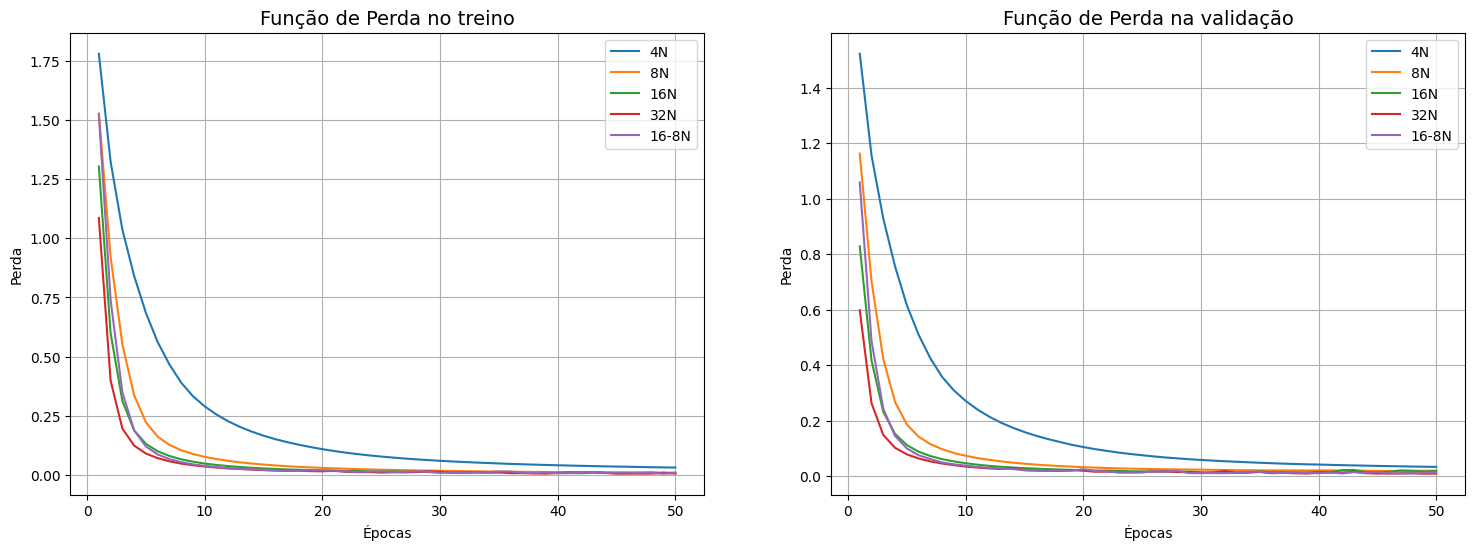

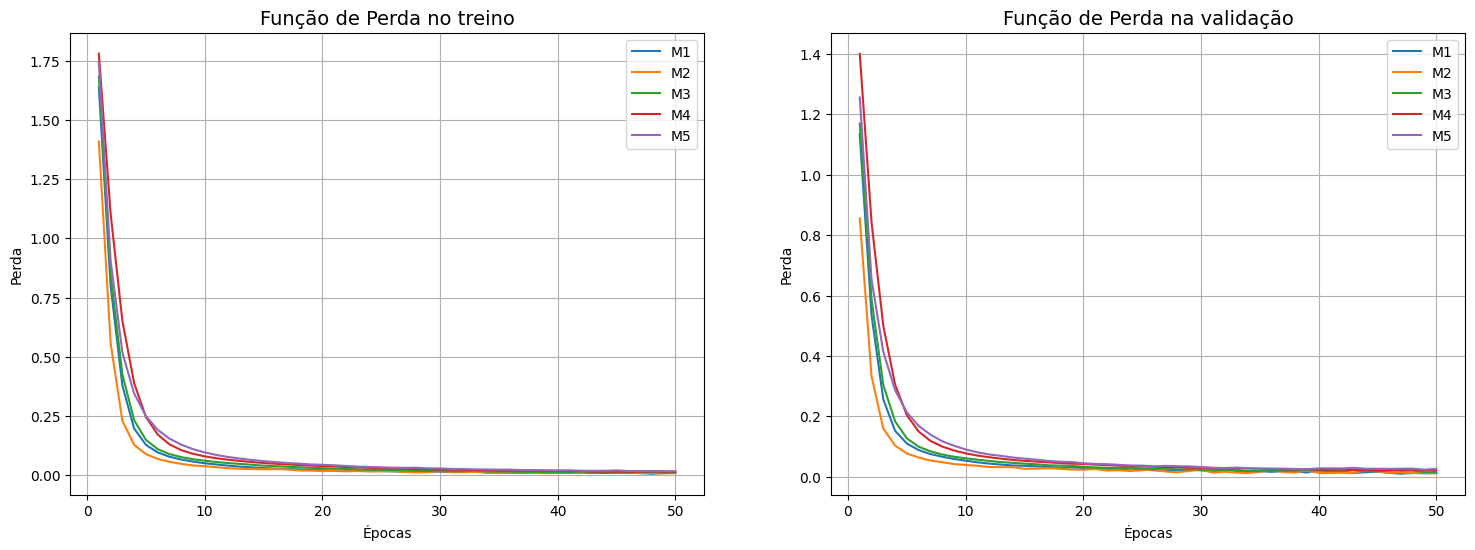

In [47]:
# Gerando gráfico da função de perda a cada época no treinamento das MLP e CNN

def plotar_curvas_loss(historico, tipo_modelo):
    # treino
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    epochs = range(1, EPOCHS + 1)
    
    for cfg, curvas in historico[tipo_modelo].items():
        ax1.plot(epochs, curvas['train'], label=f'{cfg}')
    
    ax1.set_title(f'Função de Perda no treino', fontsize=14)
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perda')
    ax1.legend()
    ax1.grid(True)

    # validação
    for cfg, curvas in historico[tipo_modelo].items():
        ax2.plot(epochs, curvas['val'], label=f'{cfg}')
    
    ax2.set_title(f'Função de Perda na validação', fontsize=14)
    ax2.set_xlabel('Épocas')
    ax2.set_ylabel('Perda')
    ax2.legend()
    ax2.grid(True)
    
    nome_saida = "./images/grafico_loss_curves" + tipo_modelo + ".png"
    plt.savefig(nome_saida, dpi=600)
    plt.show()

plotar_curvas_loss(historico_perdas, 'MLP')
plotar_curvas_loss(historico_perdas, 'CNN')

### Análise de Componentes Principais (PCA)

**Definição da Função de Plotagem**: implementa-se a função **gerar_pca()** para encapsular a lógica de redução de dimensionalidade e visualização. A função inicializa o objeto **PCA** com **n_components=2**, reduzindo as 201 dimensões originais (features de pressão) para apenas 2 componentes principais, permitindo a plotagem em um plano cartesiano.

**Estruturação dos Dados**: o método **fit_transform()** é aplicado aos dados de entrada para calcular os autovetores e projetar os dados no novo espaço reduzido. O resultado é organizado em um DataFrame do pandas contendo as colunas 'PCA1' e 'PCA2', além da coluna 'Classe' com os rótulos verdadeiros (**true_labels**), o que facilita o agrupamento visual.

**Visualização por Dispersão**: utiliza-se um loop para iterar sobre cada classe única, plotando os pontos correspondentes via **plt.scatter()**. Isso garante que cada tipo de falha seja representado por uma cor distinta e associada ao seu nome legível (via lista **nomes_classes**). O gráfico é finalizado com rótulos de eixos, título personalizado, legenda e grade.

**Visualização dos Dados Brutos (Baseline)**: a primeira chamada da função é feita passando o conjunto de teste original (**X_test**) e os rótulos inteiros (**y_test_int**). Este gráfico serve como linha de base, mostrando como as classes estão distribuídas naturalmente no espaço de entrada antes de qualquer processamento pela rede neural, correspondendo à parte superior da Figura 4 do artigo.

**Extração de Características (Hidden Layer)**: para visualizar o aprendizado da rede e contornar limitações de acesso ao grafo do modelo Sequential, reconstrói-se o fluxo de dados manualmente via API Funcional. Define-se um novo tensor de entrada (**tf.keras.Input**) e itera-se sobre as camadas já treinadas do MLP (**mlp_final.layers[:-1]**), aplicando-as sequencialmente até a penúltima camada. Um novo modelo extrator (**saida_oculta**) é instanciado conectando essa nova entrada à saída processada, isolando as representações internas (features) antes da classificação Softmax.

**Visualização das Representações Latentes**: os dados de teste são passados por esse modelo reconstruído (**saida_oculta.predict**), gerando o conjunto **X_saida_oculta**. A função **gerar_pca()** é chamada novamente com esses novos dados. O gráfico resultante demonstra a capacidade da rede neural de transformar o espaço de dados, agrupando classes que antes estavam sobrepostas e facilitando a classificação linear final, correspondendo à parte inferior da Figura 4 do artigo.

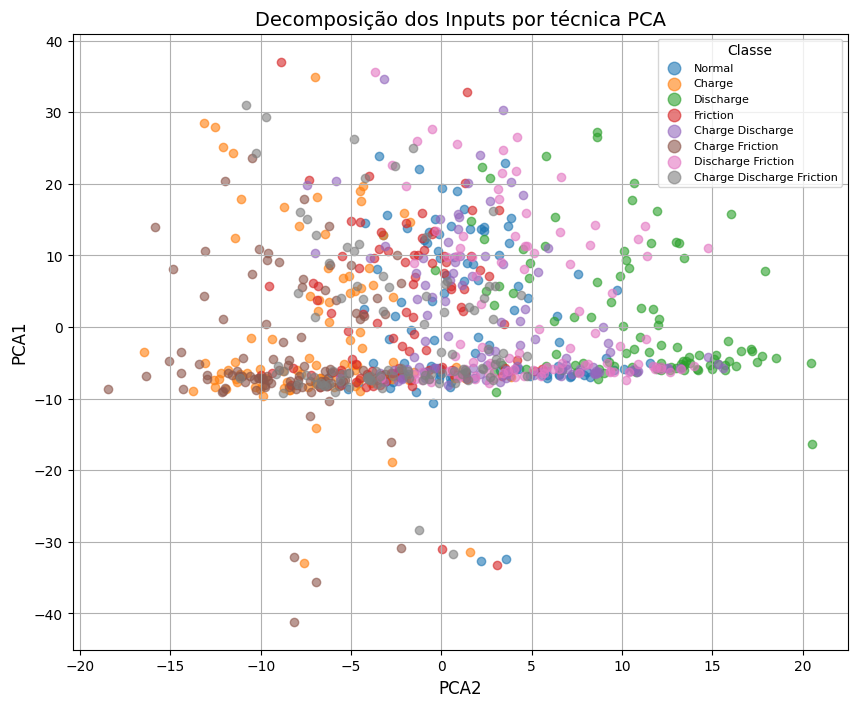

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


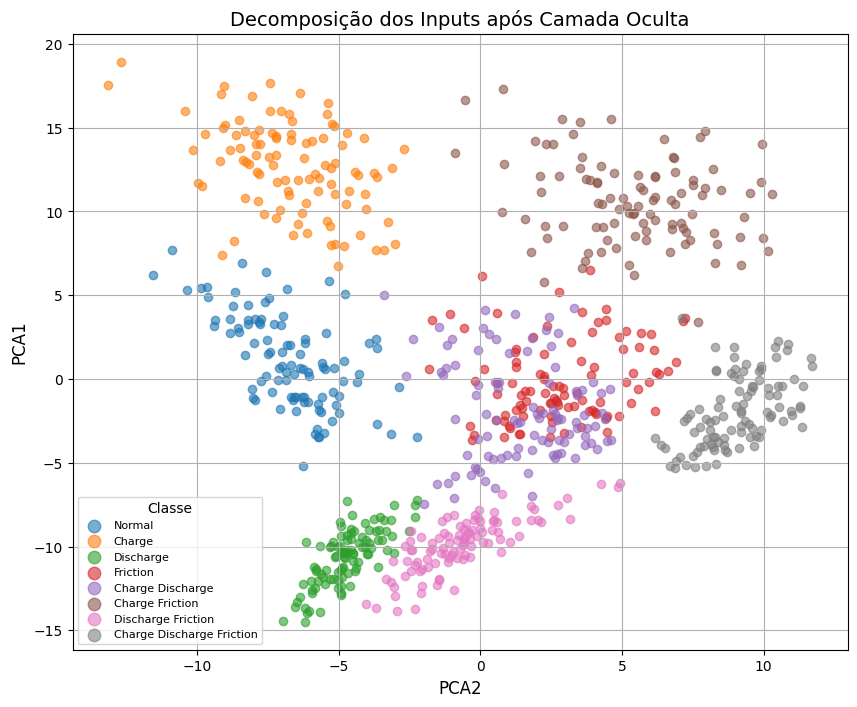

In [ ]:
# Geração do PCA para visualização da separação das classes usando o melhor MLP

def gerar_pca(dados, true_labels, titulo, nome_img):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(dados)

    df = pd.DataFrame(data=X_pca, columns=['PCA1','PCA2'])
    df['Classe'] = true_labels

    plt.figure(figsize=(10,8))

    for classe in sorted(df['Classe'].unique()):
        subset = df[df['Classe'] == classe]
        plt.scatter(
            subset['PCA2'],
            subset['PCA1'],
            label=nomes_classes[classe],
            alpha=0.6,
            marker='o'
        )
    
    plt.xlabel('PCA2', fontsize=12)
    plt.ylabel('PCA1', fontsize=12)
    plt.title(titulo, fontsize=14)
    plt.legend(title='Classe', markerscale=1.5, fontsize=8)
    plt.grid(True)
    nome_saida = "./images/PCA" + nome_img + ".png"
    plt.savefig(nome_saida, dpi=600)
    plt.show()

gerar_pca(dados=X_test, true_labels=y_test_int, titulo='Decomposição dos Inputs por técnica PCA', nome_img='_pre_camada_oculta')

# Visualizar após a camada oculta nome_img='_pos_camada_oculta'
input_tensor = tf.keras.Input(shape=(n_features,))

x = input_tensor
for layer in mlp_final.layers[:-1]:
    x = layer(x)

saida_oculta = tf.keras.models.Model(
    inputs=input_tensor,
    outputs=x
)

X_saida_oculta = saida_oculta.predict(X_test)

gerar_pca(dados=X_saida_oculta, true_labels=y_test_int, titulo='Decomposição dos Inputs após Camada Oculta', nome_img='_pos_camada_oculta')